In [1]:
%%html
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="#" onClick="code_toggle();"><h3>Click here to hide/show the code</h3></a>

# A tour of point cloud processing
### Mathieu Carette

Notebook available at https://github.com/rockestate/point-cloud-processing

Slides available at https://www.rockestate.be/point-cloud-processing/presentation/ 

(previous versions [here](https://github.com/rockestate/point-cloud-processing/releases))

# About me

- PhD in Mathematics (ULB, 2009)
- Postdocs (UIUC, UCLouvain, McGill)
- Data Scientist (KBC, Forespell)
- Now working on
<a href="https://www.rockestate.be">
    <img src="../img/rockestate-logo-notext.png" alt="Drawing" style="width: 120px;"/>
    <p style="text-align: center; font-size: xx-large;"><b>ROCKESTATE</b></p>
</a>

Favorite software stack:

<div class="imgContainer"><img src="../img/python-logo.png" alt="Python logo" style="width: 200px;"/></div>
<div class="imgContainer"><img src="../img/jupyter_logo.png" alt="Jupyter logo" style="width: 200px;"/></div>
<div class="imgContainer"><img src="../img/conda_logo.png" alt="Conda logo" style="width: 200px;"/></div>

# Where do 3D point clouds come from?

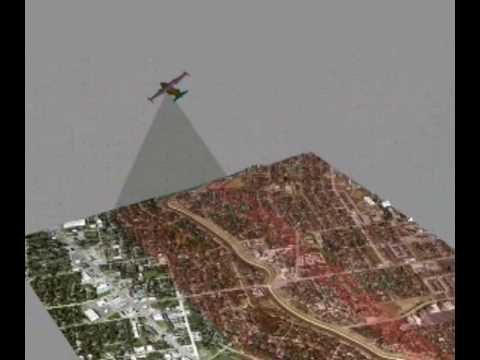

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('GSPcyhSAgTQ',start=7, end=31)

Open LiDAR data for Brussels and Flanders : https://remotesensing.agiv.be/opendata/lidar/

# File formats and software

- [LAS](https://www.asprs.org/committee-general/laser-las-file-format-exchange-activities.html) standard file format
- [LAZ](https://www.laszip.org/) compressed file format

<div class="imgContainer"><img src="../img/pcl_logo.png" alt="PCL logo" style="width: 200px;"/></div>
- [PCL](http://pointclouds.org/) **P**oint **C**loud **L**ibrary
  - Open source: https://github.com/PointCloudLibrary/pcl
  - C++
  - Powerful general purpose algorithms

<div class="imgContainer"><img src="../img/cgal_logo.png" alt="CGAL logo" style="width: 200px;"/></div>
- [CGAL](https://www.cgal.org/) **C**omputational **G**eometry **A**lgorithms **L**ibrary
  - Open source: https://github.com/CGAL/cgal
  - C++
  - State of the art 2D and 3D geometry algorithms

<div class="imgContainer"><img src="../img/pdal_logo.png" alt="PDAL logo" style="width: 200px;"/></div>
- [PDAL](https://www.pdal.io) **P**oint **D**ata **A**bstraction **L**ibrary
  - Open source: https://github.com/PDAL/PDAL
  - C++, command-line, python
  - Wraps some PCL functionality
  - For windows users: part of the [OSGeo4W](https://trac.osgeo.org/osgeo4w/) distribution

<div class="imgContainer"><img src="../img/lastools_logo.jpeg" alt="LAStools logo" style="width: 200px;"/></div>
- [LAStools](https://rapidlasso.com/lastools/) from RapidLasso
  - Proprietary, preferred pricing for academic use
  - Windows only, runs on wine
  - command-line, GUI
  - Open source [laszip](https://www.laszip.org) compression/decompression: https://github.com/LASzip/LASzip

# Let's process some point clouds

In [3]:
import glob
import io
import ipyleaflet
import IPython.display
import ipyvolume.pylab as p3
import json
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pdal
import PIL
import pyproj
import requests
import shapely.geometry
import scipy.spatial
import sys
import urllib.request

%load_ext autoreload
%autoreload 2
    
sys.path.append('../src')
from pcl_utils import local_max

# Url for aerial imagery
IVaerial = "https://geoservices.informatievlaanderen.be/raadpleegdiensten/ogw/wms?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&CRS=EPSG:31370&BBOX={0},{1},{2},{3}&WIDTH=512&HEIGHT=512&LAYERS=OGWRGB13_15VL&STYLES=default&FORMAT=image/png"

%matplotlib inline

In [4]:
# Download the LAS data file if not already present
if not os.path.isdir('../data'):
    os.makedirs('../data')
lidar_filename = 'LiDAR_DHMV_2_P4_ATL12431_ES_20140325_31195_2_150500_166500.las'
if not os.path.isfile('../data/' + lidar_filename):
    urllib.request.urlretrieve('https://s3-eu-west-1.amazonaws.com/rockestate-public/lidar/' + lidar_filename, 
                               '../data/' + lidar_filename)

In [ ]:
m = ipyleaflet.Map(center=(50.81343, 4.38188), zoom=16)
dc = ipyleaflet.DrawControl()
m.add_control(dc)
m

## Selecting street portion with a polygon
![](../img/street-leaflet.png)

POLYGON ((150687.8518289287 167058.3858805448, 150939.3740217351 167072.33228858, 150980.4548986266 166743.7380920332, 150919.5663185167 166714.6929215267, 150754.0807228128 166712.885090881, 150581.449810213 166933.4497666787, 150687.8518289287 167058.3858805448))


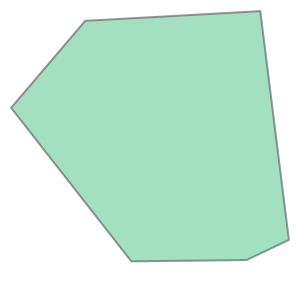

In [6]:
wsg84 = pyproj.Proj(init='epsg:4326')
lambert = pyproj.Proj(init='epsg:31370')
coords = [pyproj.transform(wsg84,lambert,x,y) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
polygon = shapely.geometry.Polygon(coords)
print(polygon.wkt)
IPython.display.display(polygon)

In [7]:
b = polygon.bounds
cropper = {
    "pipeline": [ '../data/'+ lidar_filename,
        {   "type":"filters.crop",
            'bounds':str(([b[0], b[2]],[b[1], b[3]]))},
        {   "type":"filters.crop",
            'polygon':polygon.wkt},
        {   "type":"filters.hag"},
        {   "type":"filters.eigenvalues",
            "knn":16},
        {   "type":"filters.normal",
            "knn":16}
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper))
pipeline.validate()
%time n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon.area))

CPU times: user 15.9 s, sys: 318 ms, total: 16.2 s
Wall time: 16.3 s
Pipeline selected 473184 points (4.4 pts/m2)


In [8]:
# Load Pipeline output in python objects
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})
df['X_0'] = df['X']
df['Y_0'] = df['Y']
df['Z_0'] = df['Z']
df['X'] = df['X'] - df['X_0'].min()
df['Y'] = df['Y'] - df['Y_0'].min()
df['Z'] = df['Z'] - df['Z_0'].min()

In [ ]:
fig = p3.figure(width=1000)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
all_points = p3.scatter(df['Y'], df['Z'], df['X'], color='red', size=.2)
p3.squarelim()
p3.show()

## Original data
![](../img/street-0.png)

In [10]:
# Color ground in grey
df['ground'] = df['Classification']!=1
ground = p3.scatter(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], color='red', size=.2)
non_ground = p3.scatter(df.loc[~df['ground'],'Y'], df.loc[~df['ground'],'Z'], df.loc[~df['ground'],'X'], color='red', size=.2)
fig.scatters.append(ground)
fig.scatters.append(non_ground)
all_points.visible = False
ground.color='lightgrey'

In [11]:
# Show ground as surface
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['ground'],['X','Y']])
ground_surf = p3.plot_trisurf(df.loc[df['ground'],'Y'], df.loc[df['ground'],'Z'], df.loc[df['ground'],'X'], ground_delaunay.simplices, color='lightgrey')
fig.meshes.append(ground_surf)
ground.visible=False

## Use gound / non-ground classification
![](../img/street-2.png)

In [12]:
# Color points according to flatness
df['flatness'] = df['Eigenvalue0'] 
non_ground.color=matplotlib.cm.viridis(df.loc[~df['ground'],'flatness']*4)[:,0:3]

In [13]:
# Separate between trees and the rest
df['tree_potential'] = (df['Classification']==1) & (df['HeightAboveGround'] >= 2) & (df['flatness'] > .05) &  (df['NumberOfReturns'] - df['ReturnNumber'] >= 1) 
df['other'] = ~df['ground'] & ~df['tree_potential']
tree_potential = p3.scatter(df.loc[df['tree_potential'],'Y'], df.loc[df['tree_potential'],'Z'], df.loc[df['tree_potential'],'X'], color=matplotlib.cm.viridis(df.loc[df['tree_potential'],'flatness']*4)[:,0:3], size=.2)
other = p3.scatter(df.loc[df['other'],'Y'], df.loc[df['other'],'Z'], df.loc[df['other'],'X'], color=matplotlib.cm.viridis(df.loc[df['other'],'flatness']*4)[:,0:3], size=.2)
non_ground.visible=False
tree_potential.color='darkgreen'
other.color='red'

## Use point flatness to separate trees from the rest
![](../img/street-4.png)

In [14]:
#Hide non-tree
other.visible=False

In [15]:
lep = local_max(df.loc[df['tree_potential'],['X','Y','Z','HeightAboveGround']], radius=3, density_threshold=15)

In [16]:
treetop_spheres = p3.scatter(lep['Y'], lep['Z'], lep['X'], color='red', size=.5, marker='sphere')
fig.scatters.append(treetop_spheres)

In [17]:
treetop_spheres.color = matplotlib.cm.Vega10(np.arange(len(lep['Z']))%10)[:,0:3]

## Find treetops as local maxima
![](../img/street-5.png)

In [18]:
kdtree = scipy.spatial.kdtree.KDTree(lep[['X','Y','Z']])
dist, idx = kdtree.query(df.loc[df['tree_potential'],['X','Y','Z']].values)
tree_potential.color=matplotlib.cm.Vega10(idx%10)[:,0:3]
df.loc[df['tree_potential'], 'tree_idx'] = idx

## Separate trees using closest treetop
![](../img/street-6.png)

In [19]:
medians = df.groupby('tree_idx')[['X','Y','Z']].median()
for axis in ['X','Y','Z']:
    df['d'+axis] = df[axis] - df['tree_idx'].map(medians[axis])
df['radius'] = np.linalg.norm(df[['dX', 'dY', 'dZ']].values, axis=1)
radii = pd.DataFrame([df.groupby('tree_idx')['radius'].quantile(.5), lep['HeightAboveGround'].values*.4]).min()

In [20]:
scale = max(df['X'].max() - df['X'].min(), df['Y'].max() - df['Y'].min())
treetop_spheres.x = medians['Y']
treetop_spheres.y = medians['Z']
treetop_spheres.z = medians['X']
treetop_spheres.size = radii * 100 / scale

## Model each tree individually
![](../img/street-7.png)

In [21]:
tree_potential.visible = False

In [22]:
other.visible = True
treetop_spheres.color='darkgreen'
p3.style.use('minimal')

## Final street model
![](../img/street-8.png)

# Building Modeling

In [ ]:
m2 = ipyleaflet.Map(center=(50.81343, 4.38188), zoom=17)
dc2 = ipyleaflet.DrawControl()
m2.add_control(dc2)
m2

## Selecting building with a polygon
![](../img/building-leaflet.png)

POLYGON ((150876.6899425487 166855.1808815384, 150913.4053620266 166873.7645316971, 150904.3812825281 166890.1151175071, 150861.390885691 166886.3253158694, 150876.6899425487 166855.1808815384))


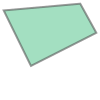

In [24]:
wsg84 = pyproj.Proj(init='epsg:4326')
lambert = pyproj.Proj(init='epsg:31370')
coords = [pyproj.transform(wsg84,lambert,x,y) for (x,y) in dc2.last_draw['geometry']['coordinates'][0]]
polygon2 = shapely.geometry.Polygon(coords)
print(polygon2)
IPython.display.display(polygon2)

In [25]:
b = polygon2.bounds
cropper = {
    "pipeline": list(glob.glob('../data/*150500_166500.las')) + [ # [ '../data/' + lidar_filename,
        {   "type":"filters.crop",
            'bounds':str(([b[0], b[2]],[b[1], b[3]]))},
        {   "type":"filters.merge"},
        {   "type":"filters.hag"},
        {   "type":"filters.crop",
            'polygon':polygon2.wkt},
        {   "type":"filters.eigenvalues",
            "knn":16},
        {   "type":"filters.normal",
            "knn":16}
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper))
pipeline.validate()
%time n_points = pipeline.execute()
print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon2.area))

CPU times: user 5.39 s, sys: 880 ms, total: 6.27 s
Wall time: 6.5 s
Pipeline selected 31223 points (28.8 pts/m2)


In [26]:
arr = pipeline.arrays[0]
description = arr.dtype.descr
cols = [col for col, __ in description]
df = pd.DataFrame({col: arr[col] for col in cols})
df['X_0'] = df['X']
df['Y_0'] = df['Y']
df['Z_0'] = df['Z']
df['X'] = df['X'] - df['X_0'].mean()
df['Y'] = df['Y'] - df['Y_0'].mean()
df['Z'] = df['Z'] - df['Z_0'].min()
df.loc[df['HeightAboveGround'] < .2,'Classification'] = 2

In [ ]:
fig = p3.figure(width=1000)
fig.xlabel='Y'
fig.ylabel='Z'
fig.zlabel='X'
ground_delaunay = scipy.spatial.Delaunay(df.loc[df['Classification'] != 1, ['X','Y']])
ground = p3.plot_trisurf(df.loc[df['Classification'] != 1,'Y'], df.loc[df['Classification'] != 1,'Z'], df.loc[df['Classification'] != 1,'X'], triangles = ground_delaunay.simplices, color='lightgrey')
non_ground = p3.scatter(df.loc[df['Classification'] == 1,'Y'], df.loc[df['Classification'] == 1,'Z'], df.loc[df['Classification'] == 1,'X'], color='red', size=.2)
p3.squarelim()
p3.show()

## Original data
![](../img/building-0.png)

In [28]:
roof_mask = (df['Classification'] == 1) & (df['HeightAboveGround'] > 7) & (df['Eigenvalue0'] <= .02) & (df['NumberOfReturns'] == df['ReturnNumber'])

In [29]:
roof_quiver = p3.quiver(df.loc[roof_mask,'Y'],df.loc[roof_mask,'Z'],df.loc[roof_mask,'X'], df.loc[roof_mask,'NormalY'], df.loc[roof_mask,'NormalZ'], df.loc[roof_mask,'NormalX'], size=2)
fig.scatters.append(roof_quiver)
non_ground.visible=False

## Visualize normals
![](../img/building-1.png)

In [30]:
roof_quiver.x = df.loc[roof_mask,'NormalY'] *15
roof_quiver.y = df.loc[roof_mask,'NormalZ'] *15 + df['Z'].median()
roof_quiver.z = df.loc[roof_mask,'NormalX'] *15

## Infer building orientation using normals
![](../img/building-2.png)

In [31]:
roof_quiver.visible = False
non_ground.visible = True

In [32]:
# Find building orientation using normals
alphas = np.linspace(0, np.pi, num=180)
magnitude = [np.abs(df.loc[roof_mask,['NormalX','NormalY']].values @ np.array([np.cos(alpha), np.sin(alpha)])).sum()
             for alpha in alphas]
angle = alphas[np.argmin(magnitude)]

In [33]:
# Rotate building to align walls with X & Y axes
Rotation = np.array([[np.cos(angle), np.sin(angle)],[-np.sin(angle), np.cos(angle)]])
df['X_r'], df['Y_r'] = (df[['X','Y']].values @ Rotation[i] for i in (0,1))
df['NormalX_r'], df['NormalY_r'] = (df[['NormalX','NormalY']].values @ Rotation[i] for i in (0,1))
ground.x, ground.z = df.loc[df['Classification']!= 1, 'Y_r'], df.loc[df['Classification']!= 1, 'X_r']
non_ground.x, non_ground.z = df.loc[df['Classification']== 1, 'Y_r'], df.loc[df['Classification']== 1, 'X_r']

## Align building orientation along X-Y axes
![](../img/building-3.png)

In [34]:
# Build 3D model in rotated coordinates
z0 = df.loc[~roof_mask,'Z'].median()
ystep = (df.loc[roof_mask,'Y_r']*4).astype(int)/4
y_profile = (df[roof_mask].groupby(ystep)['Z'].quantile(.99).rolling(window=5).min()).shift(-1).fillna(z0)
xstep = np.linspace(df.loc[roof_mask,'X_r'].quantile(.01), df.loc[roof_mask,'X_r'].quantile(.99), len(ystep.unique()))
X,Y = np.meshgrid(xstep, ystep.sort_values().unique())
Z = y_profile[Y.ravel()].values.reshape(Y.shape)

In [35]:
# Plot 3D model
df_extra = pd.DataFrame({'X_r':X.ravel(),'Y_r':Y.ravel(),'Z': Z.ravel()})
df_extra.loc[df_extra['X_r'] == df_extra['X_r'].max(), 'Z'] = z0
df_extra.loc[df_extra['X_r'] == df_extra['X_r'].min(), 'Z'] = z0
roof_delaunay = scipy.spatial.Delaunay(df_extra[['X_r','Y_r']])
roof_model = p3.plot_trisurf(df_extra['Y_r'],df_extra['Z'],df_extra['X_r'], triangles=roof_delaunay.simplices, color='red')
fig.meshes.append(roof_model)

## Model the building using axis-aligned view
![](../img/building-4.png)

In [36]:
# Go back to original coordinates
df_extra['X'], df_extra['Y'] = (df_extra[['X_r','Y_r']].values @ np.linalg.inv(Rotation)[i] for i in (0,1))
df_extra['Classification'] = 6
ground.x, ground.z = [df.loc[df['Classification']!= 1, axis] for axis in ['Y','X']]
non_ground.visible=False
roof_model.x, roof_model.z = df_extra['Y'], df_extra['X']

## Rotate back to original coordinate system
![](../img/building-5.png)

In [37]:
# Add texture to the ground
response = requests.get(IVaerial.format(*b))
texture = PIL.Image.open(io.BytesIO(response.content))
ground.u = (df.loc[df['Classification'] != 1, 'X_0'] - b[0]) / (b[2] - b[0])
ground.v = (df.loc[df['Classification'] != 1, 'Y_0'] - b[1]) / (b[3] - b[1])
ground.texture = texture

In [38]:
# ... and to the building
df_extra['X_0'] = df_extra['X'] + df['X_0'].mean()
df_extra['Y_0'] = df_extra['Y'] + df['Y_0'].mean()
roof_model.u = (df_extra['X_0'] - b[0]) / (b[2] - b[0])
roof_model.v = (df_extra['Y_0'] - b[1]) / (b[3] - b[1])
roof_model.texture = texture
p3.style.use('minimal')

## Add texture from aerial imagery
![](../img/building-6.png)

# Things to look out for

## pdal
- Fast point-in-polygon algorithm implemented
- Apache arrow support
- Conda packaging

## jupyter
- C++ jupyter kernels 
- Jupyterlab

# Thank you!